# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.6: Time Series

### 1.6.4 ARMA

We have seen two models for time series analysis - Moving Average processes, and Autoregressive processes.

The autoregressive model for predicting the value of a variable in a time series. We use the annotation $AR(n)$ for an autoregressive model with $n$ periods.

$AR(n) X_t = c + \sum_{i=0}^n{\beta_i X_{t-n+1}} + u_t$

We can simplify in the case of an AR(1) model, that is $n=1$. This simplifies further if we also assume a zero mean (which can be done by demeaning the data beforehand) and an error term that is white noise:

$AR(1) = \beta X_{t-1}$


An MA model is given as:

$MA(p) X_t = \mu + \epsilon_{t} + \sum_{i=1}^{p}\theta_i\epsilon_{t-i}$

and specifically the MA(1) process as:

$MA(1)X_t = \epsilon_t + \theta \epsilon_{t-1}$


The difference here is subtle, but critically important. For a MA model, the correlation is 0 when the time periods are different by more than 1. That is, when some effect happens that changes the value of $X_t$ (say, a sudden high impact event), it only affects the price for two time periods. After that, we are back to "business as usual". For an AR model, $X_t$ depends on $X_{t-1}$. This in turn depends on $X_{t-2}$, and so on. So that shock has an almost permanent (although significantly diminishing) effect on the value of $X_t$.

The main difference is that MA depends on the lagged error, which is iid, while the AR model depends on the lagged value, which is not.

As you might have guessed by now, ARMA is a combination of both models, and combines the predictive power of both.

An $ARMA(p, q)$ model, where $p$ is the lag in the autoregressive model and $p$ is the lag in the moving-average model is given as:

$X_t = c + \epsilon_t + \sum_{i=1}^{q}{\beta X_{t-i}} + \sum_{i=1}^{p}\theta_i\epsilon_{t-i}$

(where $c$ is the bias, and would be 0 if the data was demeaned beforehand - and therefore could be set as the overall mean)

As a general rule, one would choose the lowest $p$ and $q$ values that adequately describe the data, over larger values that have better predictive power.

To fit an ARMA model, once $p$ and $q$ have been chosen, a least squares regression will normally work, which will minimise the error term.

To choose $p$ and $q$ themselves, there are several methods. A subjective model is to use a autocorrelation function to choose a value for $p$, and then fit $q$ afterwards:

In [1]:
%run setup.ipy

In [2]:
import quandl

In [3]:
from statsmodels import api as sms

In [4]:
employment = quandl.get("FRED/NROUST").diff().dropna()

<Axes: xlabel='Date'>

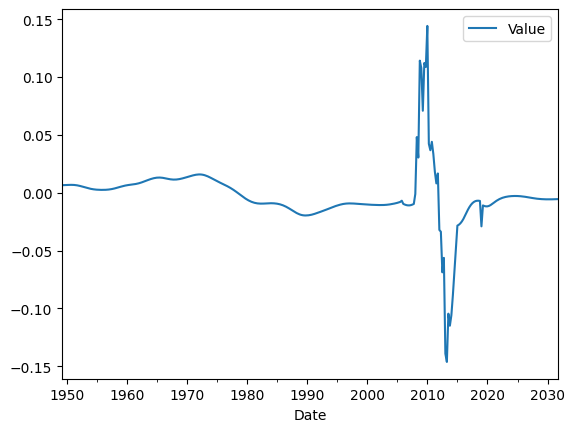

In [5]:
employment.plot()

In [7]:
pac = sms.tsa.pacf(employment)
print(pac)

[ 1.00000000e+00  9.10325544e-01  1.64006500e-01 -1.17068639e-01
 -1.70671969e-01 -2.43542723e-01 -3.16926469e-01  2.27523919e-01
 -8.67260167e-02  1.01446595e-01  4.22320164e-03  6.42350349e-02
 -4.56114717e-01 -2.78498637e-02  5.48578597e-02  2.55958185e-01
  2.15382271e-01  1.65730219e-01 -7.60981855e-02  5.18373727e-04
 -2.33140143e-01 -4.44788731e-02 -2.13912096e-01  1.44548987e-01
  1.93309229e-01 -1.45967795e-02]


In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

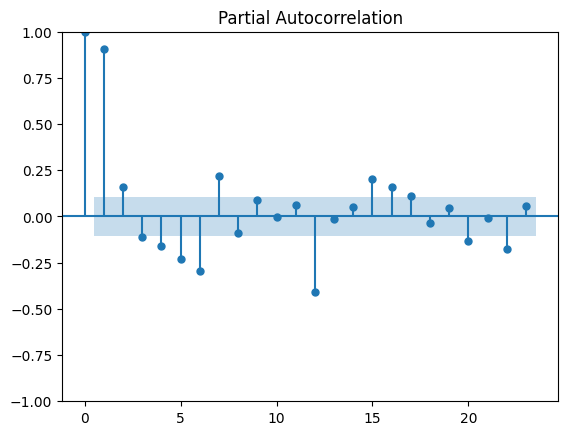

In [9]:
plot_pacf(employment, lags=np.arange(24));

A good value here might be 1 - i.e. employment moves as it did the previous month. Another good option is 12, indicating that year-on-year changes in employment are regular (which makes sense for seasonal staff).

A subjective method for choosing $q$, the lag in the MA model, is to use the full correlation function:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

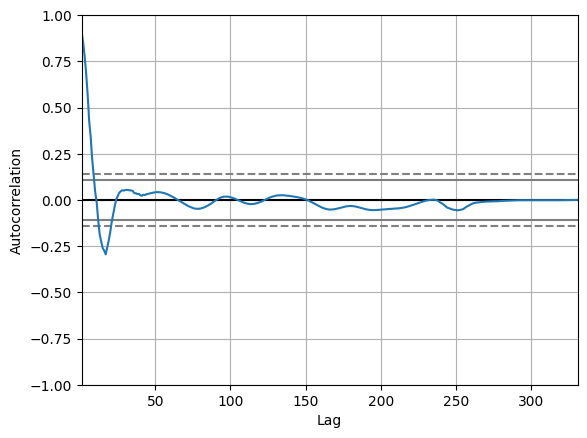

In [10]:
pd.plotting.autocorrelation_plot(employment)

In [11]:
ac = sms.tsa.acf(employment,nlags=24)

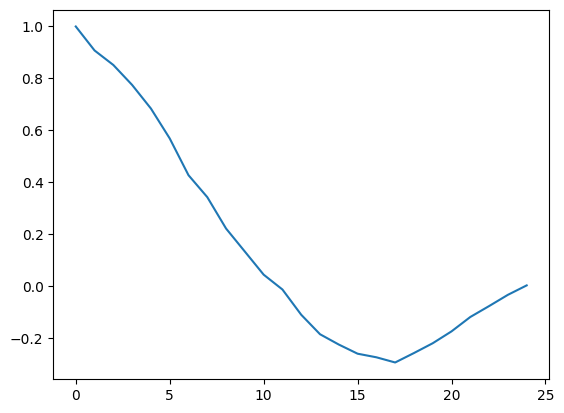

In [12]:
plt.plot(ac)

Here, perhaps a lower value is more indicative.

#### Exercise

Research the *partial autocorrelation function*, and the *autocorrelation function*. The two are different in important ways. How are they different, and what does each tell you about the data? 

The autocorrelation is the correlation of time t with time with lag n i.e. how correlated is the current day with each of previous days individually. This highlights to me how important each of these lags are individually. The partial autocorrelation is a regression of all the lags up to n, where the value is the beta of the final lag n. It controls for the intermediate lags, ie how much extra does the final lag yield above the intermediate lags. 

### Objective methods for choosing parameters

A more objective method is to try many different values for $p$ and $q$ and select the most informative, that is, the one that explains the data best. The `statsmodels` package has a useful function for this:

In [13]:
from statsmodels.tsa import stattools

In [14]:
employment.index.freq = "QS-OCT"  # Define our frequency as "quarters from October, start of month"

In [15]:
statistics = stattools.arma_order_select_ic(employment)  # May take a few minutes

/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible star

In [16]:
statistics['bic']

,0,1,2
0,-1473.728271,-1739.463070,-1876.189397
1,-2041.330410,-2041.665546,-2043.957775
2,-2043.945388,-2024.094170,-2055.411497
3,-2042.386581,-2034.084434,-2058.285490
4,-2045.349240,-2035.966562,-2026.268138


#### Exercise

Review the documentation for this function and identify:

1. What does 'bic' stand for?
2. What other options can be selected?
3. What the columns specify (i.e. $p$ or $q$)?
4. What does the index represent?
5. Which value should we select? Are higher or lower values better?
6. Find a shortcut parameter that gives us this value without the need to compute it?

*For solutions, see `solutions/bic_results.py`*

### ARMA

Once you have your parameters, fit an ARMA model using them, and review the results.

In [18]:
# from my_secrets import p, q  # No cheating! Overwrite these values yourself: p, q = ?, ?
p = 3
q = 2

In [19]:
from statsmodels import api as sms
model = sms.tsa.ARIMA(employment, order=(p,0, q))

In [20]:
results = model.fit()

/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  331
Model:                 ARIMA(3, 0, 2)   Log Likelihood                1049.450
Date:                Sat, 24 Jun 2023   AIC                          -2084.900
Time:                        17:20:28   BIC                          -2058.285
Sample:                    04-01-1949   HQIC                         -2074.285
                         - 10-01-2031                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0243      0.049     -0.498      0.618      -0.120       0.071
ar.L1         -0.7210      0.053    -13.691      0.000      -0.824      -0.618
ar.L2          0.8723      0.018     48.156      0.000       0.837       0.908
ar.L3          0.7926      0.044     17.907      0.000       0.706       0.879
ma.L1          1.6073      0.067     23.817      0.000       1.475       1.740
ma.L2          0.6540      0.068      9.586      0.000       0.520       0.788
sigma2      9.936e-05    2.4e-06     41.390      0.000    9.47e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):             22374.91
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):             397.77   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
y_pred = results.predict()

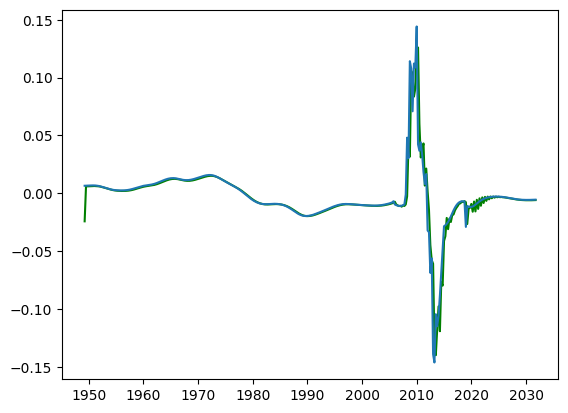

In [23]:
plt.plot(y_pred, 'g-')
plt.plot(employment)

#### Extended exercise Overfitting

Don't get too excited by that graph - our model didn't predict the wild swings in unemployment (or the underlying factor of the global financial crisis). Instead, our model has been fit *to the data*, and the data included that anomaly.

This is an effect known as *overfitting* - where the model fits the data, but doesn't learn about underlying trends.

To counter this, we split our data into two sets - a training set and a testing set. For time series data, we want to be predicting *into the future*, so we train on the first m% of the data, and evaluate on the rest.

Split the data into two groups "Everything up to 2000" and "Everything else". Train the ARMA model on the training set (the earlier data) and evaluate it on the testing data (the later data). How good does the model do?

Investigate the results further. If we *ignore* the impact of the global financial crisis (as a one-off event that can't easily be modelled with the data on hand), does it do well on the years 2000-2005, and 2012-2019?

*For solutions, see `solutions/overfitting_arma.py`*

In [41]:
# This next cell runs the solution file, in place, as if I copied the contents into this cell.
# Useful for removing large bits of code from your nice looking notebooks

/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bd/anaconda3/envs/QuantFinance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihoo

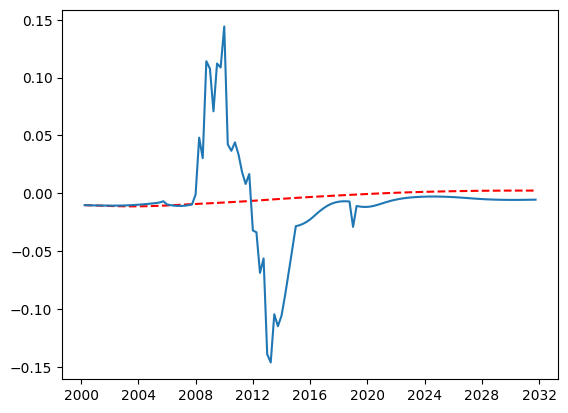

<Figure size 640x480 with 0 Axes>

In [27]:
%run -i solutions/overfitting_arma.py

### Reviewing the residuals (errors)

After fitting any model, it is worth checking the errors made by the models, ensuring there are no patterns. In many cases, your mean error will be 0, but this doesn't tell you much about the error.

To highlight this, let's look at the residuals of our model. If you haven't completed the above exercise, load the solution from the file first, run it in this notebook and then continue below


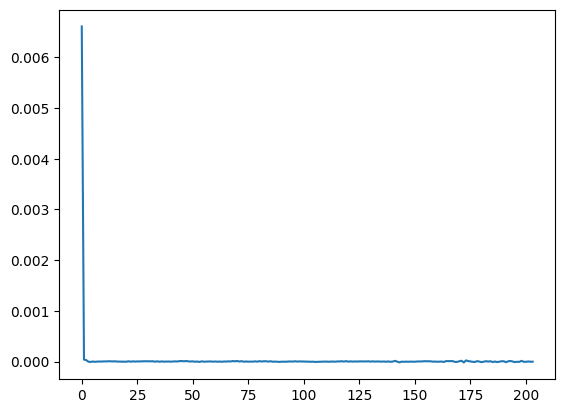

In [29]:
train_residuals = training['Value'].values - results.predict().values
plt.plot(train_residuals)

Note there is no real pattern here, indicative that it is white noise. This is the goal for our modelling - we want a model that predicts the data well, and with no pattern in the residuals. 

If there was a pattern, then we would need to work out a way to model that too.

To see an example, if we analyse the residuals of the testing dataset, we can see a clear pattern exist (note: the pattern doesn't have to be regularly repeating). There is something going on with this data, and we would need to work it out in our analysis.

In [30]:
test_residuals = testing['Value'].values - y_pred.values

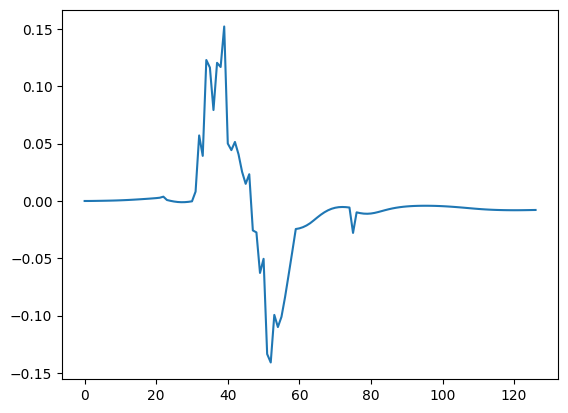

In [31]:
plt.plot(test_residuals)

#### Exercise

Perform a formal analysis to identity if the residuals are white noise in both the training and testing case.

In [35]:
import statsmodels.stats.api as sms

In [36]:
# Training
check_mean = sms.DescrStatsW(train_residuals)
print(check_mean.tconfint_mean(0.05))

n = len(train_residuals)//2
print(stats.levene(train_residuals[:n], train_residuals[n:]))

(-3.136530661702129e-05, 9.643117450829192e-05)
LeveneResult(statistic=0.9715143734375503, pvalue=0.3254819102429797)


In [37]:
# Test
check_mean = sms.DescrStatsW(test_residuals)
print(check_mean.tconfint_mean(0.05))

n = len(test_residuals)//2
print(stats.levene(test_residuals[:n], test_residuals[n:]))

(-0.010471077795575757, 0.00343794627253274)
LeveneResult(statistic=31.646639119886455, pvalue=1.1524388931121514e-07)
